# Topic Modeling on European Parliament Proceedings

Topic modeling is used to discover topics that occur in a collection of documents. This is especially useful when trying to quickly gain insights from a large corpus of documents about what the contents are without going through them thoroughly. <br>
In this notebook, we will perform topic modeling on some sections of the European Parliament proceedings transcripts taken from [here](http://www.statmt.org/europarl/).

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import numpy as np
import pickle
import re
from pathlib import Path
import pandas as pd
import pyLDAvis.gensim
path = Path('/home/lyk/Documents/datasets/europarl')

The transcripts in the years 1996 to 2005 will be analyzed. Each file represents a day where there was a hearing.

In [32]:
!ls '/home/lyk/Documents/datasets/europarl/txt/en 1996-2005'

ep-00-01-17.txt  ep-02-05-13.txt  ep-05-01-13.txt  ep-97-10-22.txt
ep-00-01-18.txt  ep-02-05-14.txt  ep-05-01-27.txt  ep-97-10-23.txt
ep-00-01-19.txt  ep-02-05-15.txt  ep-05-02-21.txt  ep-97-10-24.txt
ep-00-01-21.txt  ep-02-05-16.txt  ep-05-02-22.txt  ep-97-11-05.txt
ep-00-02-02.txt  ep-02-05-29.txt  ep-05-02-23.txt  ep-97-11-06.txt
ep-00-02-03.txt  ep-02-05-30.txt  ep-05-02-24.txt  ep-97-11-17.txt
ep-00-02-14.txt  ep-02-06-10.txt  ep-05-03-07.txt  ep-97-11-18.txt
ep-00-02-15.txt  ep-02-06-11.txt  ep-05-03-08.txt  ep-97-11-19.txt
ep-00-02-16.txt  ep-02-06-12.txt  ep-05-03-09.txt  ep-97-11-20.txt
ep-00-02-17.txt  ep-02-06-13.txt  ep-05-03-10.txt  ep-97-11-21.txt
ep-00-02-18.txt  ep-02-07-01.txt  ep-05-04-11.txt  ep-97-12-03.txt
ep-00-03-01.txt  ep-02-07-02.txt  ep-05-04-13.txt  ep-97-12-04.txt
ep-00-03-02.txt  ep-02-07-03.txt  ep-05-04-14.txt  ep-97-12-15.txt
ep-00-03-13.txt  ep-02-07-04.txt  ep-05-04-27.txt  ep-97-12-16.txt
ep-00-03-14.txt  ep-02-09-02.txt  ep-05-04-28.txt  ep-97-12-17

In [15]:
file_dates=[]
for fname in (path/'txt/en 1996-2005').glob('*.txt'):
    date = re.search('ep-(.{8}).txt',str(fname))
    if date is not None:
        file_dates.append(date.group(1))

In [16]:
series = pd.to_datetime(pd.Series(file_dates), format='%y-%m-%d')
series.index = series.dt.to_period('y')
series = series.groupby(level=0).size()

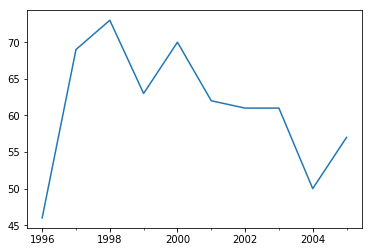

In [17]:
ax = series.plot()

In the 10 years from 1996 to 2005, 1997-1998 had the most number of hearings. To get a quick idea of what are the general topics discussed are, we can use topic modeling.

In [18]:
file_list=[]
for fname in (path/'txt/en 1997-1998').glob('*.txt'):
    file_list.append(re.sub(' +',' ',re.sub('\n',' ',(re.sub('<.+>',' ',fname.open('r').read())))))

In [19]:
len(file_list) #number of files

142

In [ ]:
tokenizer = spacy.load('en')
tok = [tokenizer(text.lower()) for text in file_list]

Stopwords, punctuations and tokens that are of length 2 and below are removed.

In [ ]:
docs = [[token.lemma_ for token in t if token.is_stop!=True and token.is_punct!=True and len(token)>2] for t in tok] 

In [ ]:
pickle.dump(docs, open(path/'ep1997-1998.pkl','wb'))

In [4]:
docs = pickle.load(open(path/'ep1997-1998.pkl','rb'))

### Word Frequencies

In [4]:
words_list=[i for s in docs for i in s]
words_string=' '.join(w for w in words_list)

In [5]:
freq=Counter(words_list)
freq.most_common(10)

[('european', 37575),
 ('commission', 29282),
 ('president', 22842),
 ('report', 21295),
 ('state', 20738),
 ('parliament', 20406),
 ('union', 19433),
 ('member', 19237),
 ('country', 16546),
 ('council', 14912)]

<BarContainer object of 10 artists>

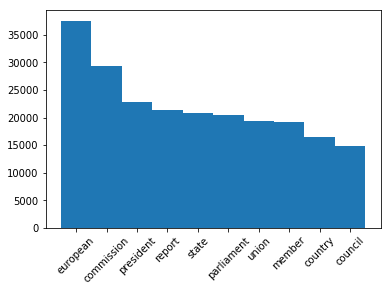

In [6]:
labels, values = zip(*freq.most_common(10))
index = np.arange(len(labels))
plt.xticks(index,labels,rotation=45)
plt.bar(index, values,1)

In [7]:
wordcloud = WordCloud(background_color='white',
                     width=1800,
                     height=1400).generate_from_frequencies(freq)

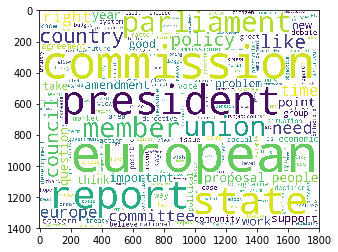

In [8]:
plt.imshow(wordcloud)

From the wordcloud and bar chart above, words referencing the organization such as European, Commission,President, State appear most frequently.

### Topic Modeling

In [5]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora, models
import logging

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


We will use Latent Dirichlet Allocation (LDA) to do topic modeling using the [gensim library](https://radimrehurek.com/gensim/models/ldamodel.html). The meaning and context in phrases such as 'green tea' or 'Empire State Building' would be lost if they were broken down to individual words. Hence, we will also use gensim's Phrases module to capture n-grams phrases where an n-gram is a sequence of n items or words. For our case, we will capture bigram (n=2) phrases that appear in at least 20 documents.

In [6]:
bigram=Phrases(docs,min_count=20)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token: #it is a bigram
            docs[idx].append(token)

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [7]:
dictionary = corpora.Dictionary(docs)

#remove tokens that appear in less than 15 documents and more than 70% of corpus
dictionary.filter_extremes(no_below=15,no_above=0.7)

corpus=[dictionary.doc2bow(text) for text in docs]

In [8]:
len(dictionary),len(corpus)

(7083, 142)

In [9]:
#logging.basicConfig(filename='gensim.log',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
%%time
#load lda model
lda = gensim.models.ldamodel.LdaModel

#set number of topics and words to show
ldamodel=lda(corpus,num_topics=10, id2word=dictionary, eval_every=1, passes=20, iterations=2000)
topics = ldamodel.show_topics(num_topics=10, num_words=10, formatted=False)

for t in range(len(topics)):
    print(f"Topic {t+1}:")
    print(", ".join(w[0] for w in topics[t][1]))

Topic 1:
animal, disease, bse, drug, beef, forest, meat, central_bank, public_health, farmer
Topic 2:
ombudsman, petition, urban, discharge, nuclear, noise, conciliation, complaint, duty_free, reactor
Topic 3:
drug, patent, common_position, advertising, tobacco, internet, appropriation, committee_budget, farmer, book
Topic 4:
nuclear, renewable, coin, single_currency, renewable_energy, emu, pension, nuclear_power, gas, emission
Topic 5:
turkey, russia, -b4, military, refugee, humanitarian, kosovo, nuclear, united_nation, russian
Topic 6:
president_office, central_bank, applicant, island, agenda_2000, candidate, applicant_country, kosovo, turkey, cardiff
Topic 7:
tobacco, animal, oil, farmer, trap, olive, discharge, wto, hong, hong_kong
Topic 8:
fishery, fishing, fish, racism, fisherman, fleet, vessel, arm, fishery_agreement, vehicle
Topic 9:
asylum, schengen, amsterdam_treaty, intergovernmental, president_office, immigration, treaty_amsterdam, refugee, intergovernmental_conference, inf

As seen above, some of the discernable topics covered are:
- Nuclear and renewable energy (Topic 4)
- Possibly the Kosovo war (Topic 5)
- Fishing concerns (Topic 8)
- Concerns over Genetically Modified Organisms (Topic 10)

<br>
We can also use the [pyLDAvis](https://github.com/bmabey/pyLDAvis) library to visualize how different the topics are in relation to each other. (Note that the topic ordering is different)

In [11]:
vis = pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)
pyLDAvis.display(vis)

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))
